# Scrape and parse reference data from public data sources
This notebook scrapes data from the Amsterdam BGT API and National Road Traffic Data Portal
(NDW). The documentation of both data sources can be found at:
- https://www.amsterdam.nl/stelselpedia/bgt-index/producten-bgt/prodspec-bgt-dgn-imgeo/
- https://docs.ndw.nu/api/trafficsigns/nl/index.html

In [1]:
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import geopandas as gpd
import shapely
from shapely.geometry import Polygon
import pandas as pd

import upcp.scrapers.ams_bgt_scraper as ams_bgt_scraper
import upcp.scrapers.ndw_scraper as ndw_scraper
import upcp.utils.las_utils as las_utils
import upcp.utils.csv_utils as csv_utils

In [2]:
BGT_FOLDER = '../datasets/Accessibility_oost/bgt/'

In [3]:
bbox = las_utils.get_bbox_from_las_folder('../datasets/Accessibility_oost/ahn3/', padding=5)
((xmin, ymax), (xmax, ymin)) = bbox
bbox_poly = Polygon([(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin), (xmin, ymin)])

## Custom 'obstakels'

In [4]:
def is_inside(row):
    poly = row['geometry']
    if isinstance(poly, shapely.geometry.base.BaseGeometry):
        return bbox_poly.contains(poly.centroid)
    else:
        return False

In [5]:
bgt_data_file = f'{BGT_FOLDER}bgt_bakken_banken_2018.csv'
data = gpd.read_file('../datasets/Accessibility_oost/obstakels_2018/bakken.gpkg')

In [6]:
data['is_inside'] = data.progress_apply(is_inside, axis=1)

  0%|          | 0/12870 [00:00<?, ?it/s]

In [7]:
df_oost = data[(data['is_inside'] == True)]

In [9]:
# This is a Shapely MULTIPOINT
df_oost["x"] = df_oost.geometry.map(lambda p: p[0].x)
df_oost["y"] = df_oost.geometry.map(lambda p: p[0].y)

/var/folders/rq/h813f9cd5xb5_vw7vwp2c0_40000gn/T/ipykernel_5628/689957925.py:2: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  df_oost["x"] = df_oost.geometry.map(lambda p: p[0].x)
/opt/anaconda3/envs/new/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/var/folders/rq/h813f9cd5xb5_vw7vwp2c0_40000gn/T/ipykernel_5628/689957925.py:3: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a mul

In [10]:
# Check for rows/objects that do not exist in 2018
df_oost['none_column'] = df_oost['type_det_o'].isnull()

/opt/anaconda3/envs/new/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [11]:
df_afvalbakken_2018 = df_oost[df_oost['none_column'] != True]
df_afvalbakken_2018.objecttype.unique()

array(['Afvalbak'], dtype=object)

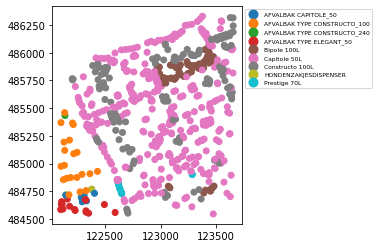

In [12]:
#%matplotlib widget
import matplotlib.pyplot as plt

params = {'legend.fontsize': 6,
          'legend.loc': 'center left'}
plt.rcParams.update(params)

fig, ax = plt.subplots(1, 1)

# data[data.is_inside].plot(ax=ax, column='type_oud', marker='.', markersize=1, legend=True)
df_afvalbakken_2018.plot(ax=ax, column='type_det_o', legend=True)
# ax.set_aspect('equal', 'box')
# Shrink current axis by 20%
box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
leg = ax.get_legend()
leg.set_bbox_to_anchor((1, 1))

plt.show()

In [13]:
# Create df in the csv format
df_afvalbakken_2018 = df_afvalbakken_2018[['x','y']]
df_afvalbakken_2018['bgt_type'] = 'afvalbak'

/var/folders/rq/h813f9cd5xb5_vw7vwp2c0_40000gn/T/ipykernel_5628/1664543152.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_afvalbakken_2018['bgt_type'] = 'afvalbak'


In [14]:
data = gpd.read_file('../datasets/Accessibility_oost/obstakels_2018/meubilair.gpkg')

In [15]:
data['is_inside'] = data.progress_apply(is_inside, axis=1)

  0%|          | 0/19117 [00:00<?, ?it/s]

In [16]:
df_oost = data[(data['is_inside'] == True)]

In [17]:
# This is a Shapely POINT
df_oost["x"] = df_oost.geometry.map(lambda p: p.x)
df_oost["y"] = df_oost.geometry.map(lambda p: p.y)

/opt/anaconda3/envs/new/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/anaconda3/envs/new/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [18]:
# Check for rows/objects that do not exist in 2018
df_oost['none_column'] = df_oost['type_det_o'].isnull()

/opt/anaconda3/envs/new/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [19]:
df_banken_2018 = df_oost[df_oost['none_column'] != True]
df_banken_2018.objecttype.unique()

array(['Banken'], dtype=object)

In [20]:
df_banken_2018 = df_banken_2018[df_banken_2018['objecttype'] == 'Banken']

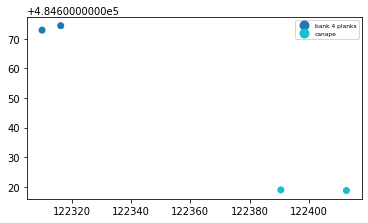

In [21]:
#%matplotlib widget
import matplotlib.pyplot as plt

params = {'legend.fontsize': 6,
          'legend.loc': 'center left'}
plt.rcParams.update(params)

fig, ax = plt.subplots(1, 1)

df_banken_2018.plot(ax=ax, column='type_det_o', legend=True)
# ax.set_aspect('equal', 'box')
# Shrink current axis by 20%
box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
leg = ax.get_legend()
leg.set_bbox_to_anchor((1, 1))

plt.show()

In [22]:
# Create df in the csv format
df_banken_2018 = df_banken_2018[['x','y']]
df_banken_2018['bgt_type'] = 'bank'
df_banken_2018 = df_banken_2018[['bgt_type', 'x','y']]

In [23]:
# Save "banken" en "bakken" dataframes to csv
df_concat = pd.concat([df_afvalbakken_2018, df_banken_2018], ignore_index=True, sort=False)
df_concat.to_csv(bgt_data_file, index=False)

In [24]:
fig.savefig('banken.png', dpi=200, bbox_extra_artists=(leg,), bbox_inches='tight')

## Scrape building footprint data from BGT

In [ ]:
# Output file for the BGT fuser.
bgt_data_file = f'{BGT_FOLDER}bgt_buildings.csv'
csv_headers = ['bgt_type', 'polygon', 'x_min', 'y_max', 'x_max', 'y_min']

bgt_layer = 'BGT_PND_pand'

In [ ]:
# Scrape data from the Amsterdam WFS, this will return a json response.
json_response = ams_bgt_scraper.scrape_amsterdam_bgt(bgt_layer, bbox=bbox)

# Parse the downloaded json response.
parsed_content = ams_bgt_scraper.parse_polygons(json_response)

# Write the csv
csv_utils.write_csv(bgt_data_file, parsed_content, csv_headers)

## Scrape road information from BGT

In [ ]:
# Output file for the BGT fuser.
bgt_data_file = f'{BGT_FOLDER}bgt_roads.csv'
csv_headers = ['bgt_type', 'polygon', 'x_min', 'y_max', 'x_max', 'y_min']
    
# Road and parking spots layers in BGT
bgt_layers = ['BGT_WGL_rijbaan_lokale_weg', 'BGT_WGL_parkeervlak',
              'BGT_WGL_rijbaan_autoweg', 'BGT_WGL_rijbaan_autosnelweg',
              'BGT_WGL_rijbaan_regionale_weg', 'BGT_WGL_ov-baan',
              'BGT_WGL_fietspad']

In [ ]:
# Scrape data from the Amsterdam WFS and parse the json.
bgt_road_polygons_csv = []
for layer in bgt_layers:
    # Scrape data from the Amsterdam WFS, this will return a json response.
    json_content = ams_bgt_scraper.scrape_amsterdam_bgt(layer, bbox=bbox)
    
    # Parse the downloaded json response.
    parsed_content = ams_bgt_scraper.parse_polygons(json_content)
    bgt_road_polygons_csv += parsed_content

# Write the csv
csv_utils.write_csv(bgt_data_file, bgt_road_polygons_csv, csv_headers)

## Scrape pole-like object locations from BGT and NDW

In [ ]:
# Output file for the BGT fuser.
bgt_data_file = f'{BGT_FOLDER}poles.csv'
csv_headers = ['bgt_type', 'x', 'y']

# BGT layers (without the traffic sign layer)
bgt_layers = ['BGTPLUS_PAL_lichtmast', 'BGTPLUS_VGT_boom']

In [ ]:
# Scrape tree and lamp post data from BGT and parse the json.
bgt_point_objects_csv = []
for layer in bgt_layers:
    # Scrape data from the Amsterdam WFS, this will return a json response.
    json_content = ams_bgt_scraper.scrape_amsterdam_bgt(layer, bbox=bbox)
    
    # Parse the downloaded json response.
    parsed_content = ams_bgt_scraper.parse_points_bgtplus(json_content)
    bgt_point_objects_csv += parsed_content

# Scrape traffic sign data from NDW. The municipality code of Amsterdam is GM0363.
json_content = ndw_scraper.scrape_ndw(town_code='GM0363')

# Parse the downloaded json response.
parsed_content = ndw_scraper.parse_traffic_signs(json_content, bbox)
bgt_point_objects_csv += parsed_content

# Write the csv
csv_utils.write_csv(bgt_data_file, bgt_point_objects_csv, csv_headers)

## Scrape street furniture object locations from BGT
Please note, <x,y> coordinates for the bgt layers "BGTPLUS_BAK_afvalbak" and "BGTPLUS_SMR_bank" are not available for the example point cloud tiles. Therefore, manually generated data is provided in this repository for demonstration purposes.

In [ ]:
# Output file for the BGT fuser.
bgt_data_file = f'{BGT_FOLDER}bgt_street_furniture.csv'
csv_headers = ['bgt_type', 'x', 'y']

# BGT layers
bgt_layers = ['BGTPLUS_BAK_afvalbak', 'BGTPLUS_SMR_bank']

In [ ]:
# Scrape street furniture data from BGT and parse the json.
bgt_point_objects_csv = []
for layer in bgt_layers:
    # Scrape data from the Amsterdam WFS, this will return a json response.
    json_content = ams_bgt_scraper.scrape_amsterdam_bgt(layer, bbox=bbox)
    
    # Parse the downloaded json response.
    parsed_content = ams_bgt_scraper.parse_points_bgtplus(json_content)
    bgt_point_objects_csv += parsed_content

# Write the csv (uncomment when data is available)
# csv_utils.write_csv(bgt_data_file, bgt_point_objects_csv, csv_headers)